<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Maxim Kashirin, ODS Slack nickname: Maxim Kashirin
    
## <center> Prediction of changes in the ruble exchange rate on Lenta.ru news

**Research plan**
     - Dataset and features description
     - Exploratory data analysis
     - Visual analysis of the features
     - Patterns, insights, pecularities of data
     - Data preprocessing
     - Feature engineering and description
     - Cross-validation, hyperparameter tuning
     - Validation and learning curves
     - Prediction for hold-out and test samples
     - Model evaluation with metrics description
     - Conclusions

### Part 1. Dataset and features description

This individual project considers the task of predicting the change in the exchange rate of the national currency of Russia based on news in one of the major Internet publications Lenta.ru. The original dataset with news in Russian but all important things are translated into English.
Economic and geopolitical events affect the exchange rate, while the exchange rate itself affects people's lives. Predicting exchange rate changes can be useful for better management of your personal budget.

There is no dataset that fully satisfies the requirements. It needs to be assembled from two other datasets.

**Lenta.ru news [dataset](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta)**

1. tags - news tag or subcategory, categorical;
1. text - news text, text;
1. title - news title, text;
1. topic - news topic (category), categorical;
1. url - news url (format: https://lenta.ru/news/year/month/day/slug/), text

**Russian financial indicators (download from [investing.com](https://www.investing.com/currencies/usd-rub-historical-data))**
1. date - rate date, datetime 2001-2018;
1. price - ruble to dollar rate (in rubles for one dollar), float;
1. change% - percentage change from previous day, float;


Then generate new dataset with news and exchange rate:

1. date
1. price
1. tags
1. text
1. title
1. topic
1. url
1. change% - target variable

Precomputed data: https://goo.gl/jKQzDb

Original data: https://goo.gl/yE8g6m

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import KFold
from urllib.parse import urlparse
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import gc
import warnings
warnings.filterwarnings('ignore')

In the beginning to comply with the conditions it is necessary to translate part of the data set

In [2]:
news_df = pd.read_csv('./data/news_lenta_orig.csv')
mapping = {
    'Все': 'Все (All)',
    'Политика': 'Политика (Politics)',
    'Общество': 'Общество (Society)',
    'Украина': 'Украина (Ukraine)',
    'Происшествия': 'Происшествия (Accidents)',
    'Футбол': 'Футбол (Football)',
    'Госэкономика': 'Госэкономика (Government economy)',
    'Кино': 'Кино (Movies)',
    'Бизнес': 'Бизнес (Business)',
    'Интернет': 'Интернет (WWW)',
    'Наука': 'Наука (Science)',
    'Следствие и суд': 'Следствие и суд (Investigation and trial)',
    'Музыка': 'Музыка (Music)',
    'Люди': 'Люди (People)',
    'Преступность': 'Преступность (Crime)',
    'Космос': 'Космос (Space)',
    'События': 'События (Events)',
    'Конфликты': 'Конфликты (Conflicts)',
    'Coцсети': 'Coцсети (Social networks)',
    'Летние виды': 'Летние виды (Summer sports)',
    'ТВ и радио': 'ТВ и радио (TV and radio)',
    'Деловой климат': 'Деловой климат (Business relationship)',
    'Криминал': 'Криминал (Crime)',
    'Явления': 'Явления (Phenomena)',
    'Регионы': 'Регионы (Regions)',
    'Гаджеты': 'Гаджеты (Gadgets)',
    'Мир': 'Мир (World)',
    'Бокс и ММА': 'Бокс и ММА (Boxing and MMA)',
    'Игры': 'Игры (Games)',
    'Звери': 'Звери (Wild)',
    'Стиль': 'Стиль (Style)',
    'Искусство': 'Искусство (Art)',
    'Пресса': 'Пресса (Press)',
    'Рынки': 'Рынки (Markets)',
    'Зимние виды': 'Зимние виды (Winter sports)',
    'Полиция и спецслужбы': 'Полиция и спецслужбы (Police and special services)',
    'Кавказ': 'Кавказ (Caucasus)',
    'Москва': 'Москва (Moscow)',
    'Деньги': 'Деньги (Money)',
    'Прибалтика': 'Прибалтика (Baltic)',
    'Книги': 'Книги (Books)',
    'Театр': 'Театр (Theatre)',
    'Техника': 'Техника (Technology)',
    'Средняя Азия': 'Средняя Азия (Middle Asia)',
    'Мировой бизнес': 'Мировой бизнес (World Business)',
    'Хоккей': 'Хоккей (Hockey)',
    'Белоруссия': 'Белоруссия (Belorussia)',
    'Движение': 'Движение (Movement)',
    'ОИ-2018': 'ОИ-2018 (Olympic games 2018)',
    'Оружие': 'Оружие (Weapon)',
    'Инструменты': 'Инструменты (Tools)',
    'Казахстан': 'Казахстан (Kazakhstan)',
    'Достижения': 'Достижения (Achievements)',
    'Софт': 'Софт (Software)',
    'Россия': 'Россия (Russia)',
    'Внешний вид': 'Внешний вид (Appearance)',
    'Часы': 'Часы (Watch)',
    'Мнения': 'Мнения (Opinions)',
    'Вирусные ролики': 'Вирусные ролики (Viral)',
    'Мемы': 'Мемы (Memes)',
    'Еда': 'Еда (Food)',
    'Молдавия': 'Молдавия (Moldavia)',
    'Катастрофы': 'Катастрофы (Disasters)',
    'Вещи': 'Вещи (clothes)',
    'Реклама': 'Реклама (Advertisement)',
    'Автобизнес': 'Автобизнес (Car business)',
    'История': 'История (History)',
    'Жизнь': 'Жизнь (Life)',
    'Финансы компаний': 'Финансы компаний (Finance companies)',
    'Авто': 'Авто (Cars)',
    'Киберпреступность': 'Киберпреступность (Cybercrime)',
    'Туризм': 'Туризм (Tourism)',
    'Преступная Россия': 'Преступная Россия (Criminal Russia)',
    'Первая мировая': 'Первая мировая (World War I)',
    'Социальная сфера': 'Социальная сфера (Social Sphere)',
    'Экология': 'Экология (Ecology)',
    'Наследие': 'Наследие (Legacy)',
    'Госрегулирование': 'Госрегулирование (Government regulation)',
    'Производители': 'Производители (Manufacturers)',
    'Вкусы': 'Вкусы (Taste)',
    'ЧМ-2018': 'ЧМ-2018 (World cup 2018)',
    'Аналитика рынка': 'Аналитика рынка (Market Analytics)',
    'Фотография': 'Фотография (Photos)',
    'Крым': 'Крым (Crimea)',
    'Страноведение': 'Страноведение (Geography)',
    'Выборы': 'Выборы (Elections)',
    'Мировой опыт': 'Мировой опыт (World experience)',
    'Вооружение': 'Вооружение (Armament)',
    'Культпросвет': 'Культпросвет (Cultural enlightenment)',
    'Инновации': 'Инновации (Innovation)'
}
news_df['tags'] = news_df['tags'].map(mapping)
mapping = {
    'Россия': 'Россия (Russia)',
    'Мир': 'Мир (World)',
    'Экономика': 'Экономика (Economy)',
    'Спорт': 'Спорт (Sport)',
    'Культура': 'Культура (Culture)',
    'Бывший СССР': 'Бывший СССР (Former USSR)',
    'Наука и техника': 'Наука и техника (Science and technology)',
    'Интернет и СМИ': 'Интернет и СМИ (Internet and media)',
    'Из жизни': 'Из жизни (Life stories)',
    'Силовые структуры': 'Силовые структуры (Security or military services)',
    'Бизнес': 'Бизнес (Business)',
    'Ценности': 'Ценности (Values)',
    'Путешествия': 'Путешествия (Travels)',
    '69-я параллель': '69-я параллель (69th parallel)',
    'Крым': 'Крым (Crimea)',
    'Культпросвет ': 'Культпросвет  (Cultural enlightenment)',
    'Легпром': 'Легпром (Light industry)',
    'Библиотека': 'Библиотека (Library)',
    'Дом': 'Дом (Home)',
    'Оружие': 'Оружие (Weapon)',
    'ЧМ-2014': 'ЧМ-2014 (World Cup 2014)',
    'МедНовости': 'МедНовости (Medicine)',
    'Сочи': 'Сочи (Sochi)'
}
news_df['topic'] = news_df['topic'].map(mapping)
news_df.to_csv('./data/news_lenta.csv', index=False)

The exchange rate needs a little preprocessing

In [3]:
currency_df = pd.read_csv('./data/usd_orig.csv')
currency_df.drop(["open","max","min"], inplace=True, axis=1)
currency_df['date'] = pd.to_datetime(currency_df['date'])
currency_df['price'] = currency_df['price'].apply(lambda x: x.replace(',', '.'))
currency_df['change%'] = currency_df['change%'].apply(lambda x: x.replace(',', '.').replace('%', ''))
currency_df.to_csv('./data/usd.csv', index=False)

Load currency exchange data

In [4]:
currency_df = pd.read_csv('./data/usd.csv', parse_dates=['date', ])

Load Lenta.ru news

In [5]:
news_df = pd.read_csv('./data/news_lenta.csv')

Original dataset doesn't contain 'publication date' feature but it can be extracted from url

In [6]:
def parse_date_from_url(x):
    path = urlparse(x).path.strip('/').split('/')
    return datetime.datetime(int(path[1]), int(path[2]), int(path[3]))

news_df['date'] = news_df['url'].apply(parse_date_from_url)

Now we can combine datasets

In [7]:
full_df = currency_df.merge(news_df,  on='date', how='inner', suffixes=('_currency', '_news'))
# full_df.to_csv('./data/data.csv', index=False)

Delete redundant variables to save memory (currency_df will need later)

In [8]:
del news_df

### Part 2. Exploratory data analysis

Let's see on dataset

In [9]:
print(f'Number of rows: {full_df.shape[0]}')
full_df.head()

Number of rows: 547648


,date,price,change%,tags,text,title,topic,url
0,2018-07-11,66.3182,0.28,Люди (People),Сотрудник австралийского зоопарка сделал предл...,Тигр помог смотрителю зоопарка сделать предлож...,Из жизни (Life stories),https://lenta.ru/news/2018/07/11/tiger/
1,2018-07-11,66.3182,0.28,Футбол (Football),"Агент Жорже Мендеш, представляющий интересы на...",Раскрыт сценарий завершения карьеры Роналду,Спорт (Sport),https://lenta.ru/news/2018/07/11/ronaldo_theend/
2,2018-07-11,66.3182,0.28,Общество (Society),Законопроект «О государственных гарантиях прав...,Госдума отказалась принимать закон о равенстве...,Россия (Russia),https://lenta.ru/news/2018/07/11/gender/
3,2018-07-11,66.3182,0.28,Госэкономика (Government economy),Пенсионный возраст для женщин может быть сниже...,Женщин захотели отпускать на пенсию раньше,Экономика (Economy),https://lenta.ru/news/2018/07/11/pension_sooner/
4,2018-07-11,66.3182,0.28,Политика (Politics),Российский МИД отреагировал на критику лидеров...,Российский МИД назвал НАТО бесполезным военным...,Мир (World),https://lenta.ru/news/2018/07/11/ya_poshel/


Data in dataset has following types:

In [10]:
full_df.dtypes

date       datetime64[ns]
price             float64
change%           float64
tags               object
text               object
title              object
topic              object
url                object
dtype: object

The following time period is considered in dataset:

In [11]:
f'Period: from {full_df["date"].min().date()} to {full_df["date"].max().date()}'

'Period: from 2001-01-10 to 2018-07-20'

Let's see numeric features:

In [12]:
full_df[['price', 'change%',]].describe()

,price,change%
count,547648.000000,547648.000000
mean,38.683936,0.022947
std,14.959095,0.896923
min,23.156000,-10.270000
25%,28.644000,-0.280000
50%,31.166000,0.000000
75%,56.369500,0.280000
max,82.681300,10.770000


Explore the distribution of numerical values

In [13]:
for col_label in ['price', 'change%']:
    col = full_df[col_label]
    col_mean = col.mean()
    _, normal_distribution_probability = stats.normaltest(col)
    skewness = stats.skew(col)
    print(col_label + ':')
    print(f'    Mean: {col_mean}')
    print(f'    Normal distribution probability: {normal_distribution_probability}')
    print(f'    Skewness: {skewness}')

price:
    Mean: 38.683936299223916
    Normal distribution probability: 0.0
    Skewness: 1.0247324627892749
change%:
    Mean: 0.022947477211634846
    Normal distribution probability: 0.0
    Skewness: 0.4297922818133429


Target variable "change%" means approximately equal to zero, target variable not distributed normally

Consider the tags that are used in dataset

In [14]:
pd.Series(full_df['tags'].unique())

0                                         Люди (People)
1                                     Футбол (Football)
2                                    Общество (Society)
3                     Госэкономика (Government economy)
4                                   Политика (Politics)
5                                     Украина (Ukraine)
6                                       Наука (Science)
7                                             Все (All)
8                                          Звери (Wild)
9                                     Бизнес (Business)
10                                       Музыка (Music)
11                                       Интернет (WWW)
12                            Достижения (Achievements)
13                                     Криминал (Crime)
14                                  Прибалтика (Baltic)
15                            Coцсети (Social networks)
16            Следствие и суд (Investigation and trial)
17    Полиция и спецслужбы (Police and special s

Let's explore topics:

In [15]:
pd.Series(full_df['topic'].unique())

0                               Из жизни (Life stories)
1                                         Спорт (Sport)
2                                       Россия (Russia)
3                                   Экономика (Economy)
4                                           Мир (World)
5                             Бывший СССР (Former USSR)
6              Наука и техника (Science and technology)
7                                    Культура (Culture)
8                                     Бизнес (Business)
9                   Интернет и СМИ (Internet and media)
10                       69-я параллель (69th parallel)
11    Силовые структуры (Security or military services)
12                                Путешествия (Travels)
13                                    Ценности (Values)
14                                        Крым (Crimea)
15               Культпросвет  (Cultural enlightenment)
16                                                  NaN
17                                           Дом

### Part 3. Visual analysis of the features

**Target variable**

In [16]:
# For simplicity, we will use dataset with the exchange rate
target_variable_exploration_df = currency_df.copy()
target_variable_exploration_df['year_month'] = target_variable_exploration_df['date']\
    .apply(lambda x: datetime.datetime(x.year, x.month, 1))

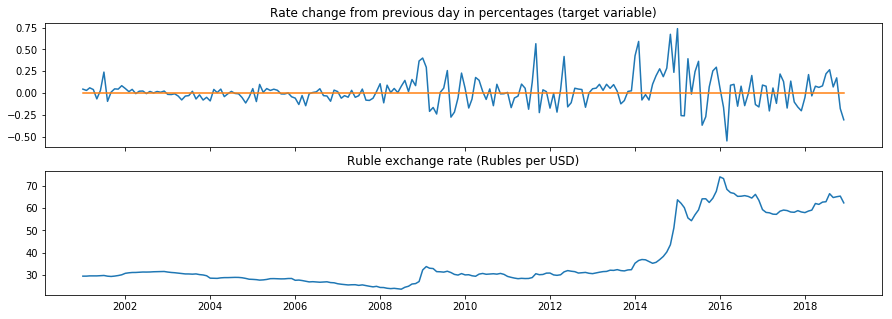

In [17]:
tve_df_by_year_month = target_variable_exploration_df.groupby('year_month')

mean_values = tve_df_by_year_month.mean()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))
ax1.set_title('Rate change from previous day in percentages (target variable)')
ax1.plot(
    mean_values.index, 
    mean_values['change%'],
    mean_values.index, 
    np.zeros(len(mean_values.index)))
ax2.set_title('Ruble exchange rate (Rubles per USD)')
ax2.plot(
    mean_values.index, 
    mean_values['price'])

* Until 2008, the rate is stable
* Then there is a sharp increase in the value of USD (see https://en.wikipedia.org/wiki/Great_Recession_in_Russia)
* Until 2014, again, the course is stable at around 40,
* Then comes the financial crisis (see https://en.wikipedia.org/wiki/Russian_financial_crisis_(2014%E2%80%932017)) and the value of the USD rises sharply again.

Consider the data in the context of each year.

In [18]:
full_df_with_year = full_df.copy()
full_df_with_year['year'] = full_df['date'].apply(lambda x: x.year)
year_group = full_df_with_year.groupby('year')

Number of news per year:

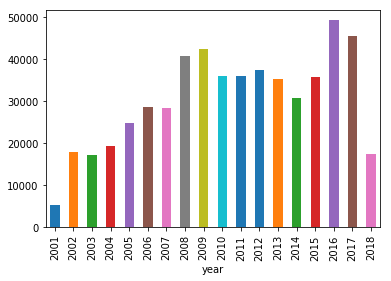

In [19]:
year_group['date'].count().plot(kind='bar')

News topics per year:

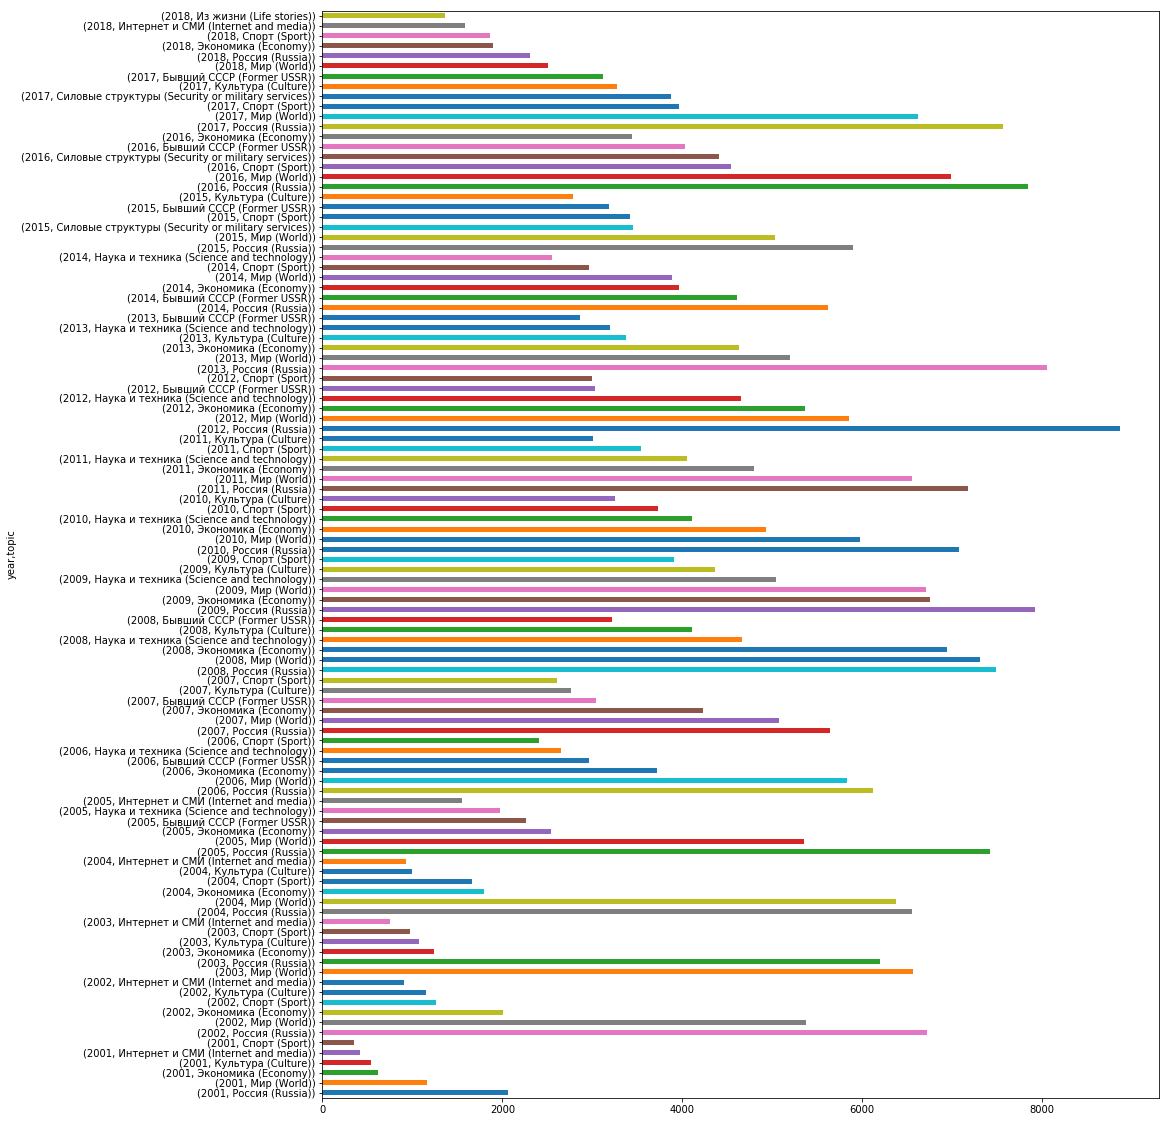

In [20]:
year_group['topic'].value_counts().groupby(level=0).head(6).plot(kind='barh', figsize=(15,20))

News tags per year:

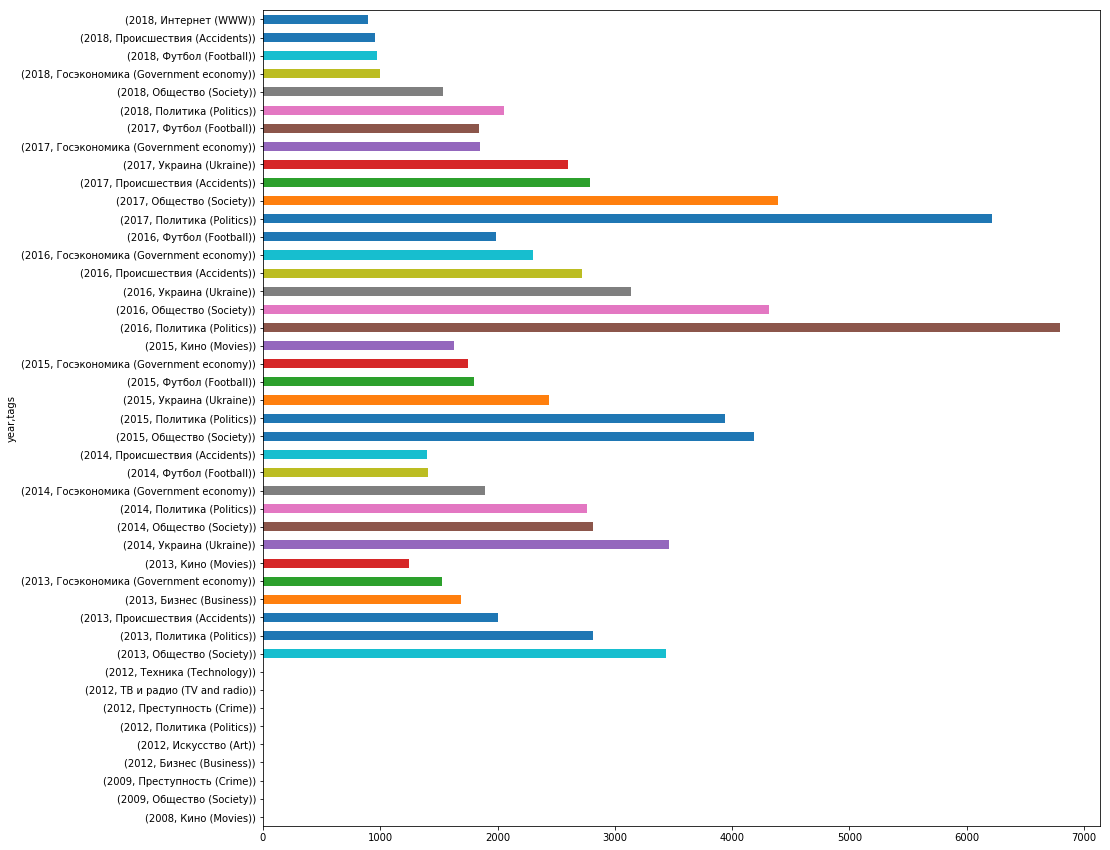

In [21]:
tags_per_years = year_group['tags'].value_counts()
tags_per_years.drop(['Все (All)'], level=1, inplace=True)
tags_per_years.groupby(level=0).head(6).plot(kind='barh', figsize=(15,15))

In [22]:
gc.collect()

99

**Conclusion**

* Exchange rate is unstable. There are drastic changes in values;
* Every year the number of articles grew. In 2014 there is an exception: the number of articles is less than in 2013 and 2015;
* The most popular topics are 'Russia' and 'World';
* The most popular tags are 'Society', 'Ukraine', 'Politics';
* Until 2013 there are no tags.

### Part 4. Patterns, insights, pecularities of data 

Consider the value of the target variable in different time sections.

In [23]:
target_variable_exploration_df['month'] = target_variable_exploration_df['date']\
    .apply(lambda x: x.month)
target_variable_exploration_df['day_of_month'] = target_variable_exploration_df['date']\
    .apply(lambda x: x.day)
target_variable_exploration_df['day_of_week'] = target_variable_exploration_df['date']\
    .apply(lambda x: x.weekday())

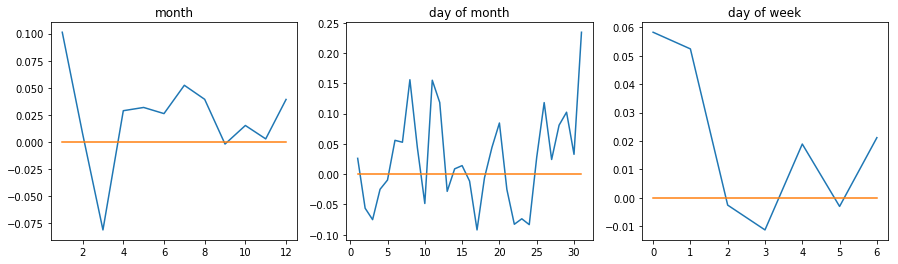

In [24]:
tve_df_by_month = target_variable_exploration_df.groupby('month')
tve_df_by_dom = target_variable_exploration_df.groupby('day_of_month')
tve_df_by_dow = target_variable_exploration_df.groupby('day_of_week')
mean_values = tve_df_by_month.mean(), tve_df_by_dom.mean(), tve_df_by_dow.mean()
titles = 'month', 'day of month', 'day of week'

fig, axis = plt.subplots(1, 3, figsize=(15,4))
for i in range(3):
    axis[i].set_title(titles[i])
    axis[i].plot(
        mean_values[i].index, 
        mean_values[i]['change%'],
        mean_values[i].index, 
        np.zeros(len(mean_values[i].index)))

Let's use NLTK library and mystem for text normalization. 
* NLTK is a leading platform for building Python programs to work with human language data. 
* The program MyStem performs a morphological analysis of the text in Russian.

In [25]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation, whitespace

[nltk_data] Downloading package stopwords to /home/maxim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
mystem = Mystem() 
# set has O(1) for "in" operation 
russian_stopwords = set(stopwords.words("russian"))
ext_punctuation = set(punctuation + '«»')
whitespace_set = set(whitespace + '\xa0')

# text to normalized list of words
def tokenize_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token not in whitespace_set\
              and token.strip() not in ext_punctuation]
    return tokens

# text to normalized text 
def preprocess_text(text):
    return " ".join(tokenize_text(text))

We will try to find the days in which the course jumps were the strongest and analyze the agenda.

In [27]:
abs_quantile = full_df['change%'].apply(np.abs).quantile(0.995)
print(f'Analyze days with |change%| more than {abs_quantile}')
change999_df = full_df[(full_df['change%'].apply(np.abs) > abs_quantile)]
print(f'News count: {change999_df["topic"].shape[0]}')

Analyze days with |change%| more than 4.68
News count: 2662


In [28]:
change999_df['date'].value_counts().sort_index()

2009-09-14    149
2009-09-15    182
2009-09-16    191
2009-09-17    179
2009-09-22    171
2009-09-23    172
2009-10-09    169
2009-12-01    176
2014-02-12    124
2014-12-15    162
2014-12-16    172
2014-12-17    173
2014-12-19    153
2014-12-29    149
2015-01-26    154
2016-01-22    186
Name: date, dtype: int64

The strongest jumps of the course were in the second half of 2009 and in December 2014

In [29]:
change999_df['topic'].value_counts().head()

Россия (Russia)                             483
Мир (World)                                 415
Экономика (Economy)                         364
Наука и техника (Science and technology)    304
Бывший СССР (Former USSR)                   219
Name: topic, dtype: int64

In [30]:
change999_df['tags'].value_counts().head()

Все (All)                            1392
Политика (Politics)                   132
Общество (Society)                     96
Госэкономика (Government economy)      81
Происшествия (Accidents)               68
Name: tags, dtype: int64

Unfortunately, until 2012 there are no tags (all marked with the tag "All"), so tags in 2009 cannot be assessed. However, in 2014, the "Politics" stands out higher than in the total sample. The "World" topic in the general set takes the 3rd place in 2009 and the 4th place in 2014, while for the days in question it is in second place with a small margin from the first. From this we can conclude that the news in the topic "World" with the tag "Politics" can most of all influence the exchange rate.

For this data subset let's try to find the most popular words which contained in titles

In [31]:
world_politics = change999_df[
    (change999_df['topic'] == 'Мир (World)') & (change999_df['tags'] == 'Политика (Politics)')]
titles = world_politics['title'].apply(tokenize_text).values
flat_list = [item.lower() for sublist in titles for item in sublist]
word_counts = list(Counter(flat_list).items())
word_counts_df = pd.DataFrame(word_counts, columns=['word', 'count']).sort_values(by=['count', 'word'], ascending=False)

top10_word_df = word_counts_df.iloc[:10]
# Перевод слов
translation_series = pd.Series([
        'sanctions', 
        'Russia',
        'USA', 
        'against',
        'president',
        'call', 
        'Relation',
        'Obama',
        'Moscow',
        'Cuba'
], index=top10_word_df.index)

top10_word_df = pd.concat([translation_series, top10_word_df], axis=1)
top10_word_df

,0,word,count
36,sanctions,санкция,12
20,Russia,россия,11
9,USA,сша,9
135,against,против,6
48,president,президент,6
16,call,называть,6
46,Relation,отношение,5
191,Obama,обама,5
23,Moscow,москва,4
190,Cuba,куба,4


The most popular word turned out to be “sanctions”, it was repeated 12 times in the reviewed headlines, then the sides of this interaction “USA” and “Russia”.

For comparison, consider the most popular words in the titles throughout the dataset.

In [32]:
all_titles = full_df['title'].apply(tokenize_text).values
flat_list = [item.lower() for sublist in all_titles for item in sublist]
word_counts = list(Counter(flat_list).items())
word_counts_df = pd.DataFrame(word_counts, columns=['word', 'count']).sort_values(by=['count', 'word'], ascending=False)
word_counts_df.head(30)

top10_word_df = word_counts_df.iloc[:10]
# Перевод слов
translation_series = pd.Series([
        'Russia', 
        'Russian',
        'USA', 
        'new',
        'year',
        'Moscow', 
        'call',
        'court',
        'dollar',
        'person'
], index=top10_word_df.index)

top10_word_df = pd.concat([translation_series, top10_word_df], axis=1)
top10_word_df

,0,word,count
91,Russia,россия,32851
23,Russian,российский,20125
406,USA,сша,19035
48,new,новый,16832
157,year,год,16471
503,Moscow,москва,15040
25,call,называть,12910
269,court,суд,11957
321,dollar,доллар,11072
731,person,человек,10853


In general, "sanction" is not a popular word.

Also consider the number of articles in the considered headings in different years.

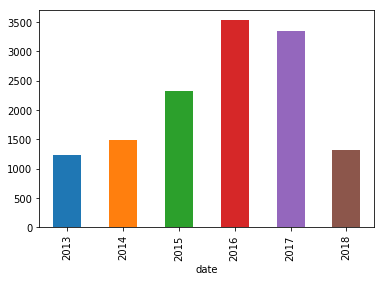

In [33]:
all_world_politics = full_df[(full_df['topic'] == 'Мир (World)') & (full_df['tags'] == 'Политика (Politics)')]
year = all_world_politics['date'].apply(lambda x: x.year)
all_world_politics_group = all_world_politics.groupby(year)
all_world_politics_group['title'].count().plot(kind='bar')

**Conclusion**

* Day, day of the week and season can be useful as features. For example, in winter and summer, the currency rate increases, and in the off season, on the contrary, it decreases.
* During the sharp changes in the exchange rate in the news, the most publications were about sanctions against Russia and the most popular tag is "Politics" and the most popular topic is "World".


In [34]:
del change999_df, world_politics, titles, flat_list, word_counts_df, all_world_politics, all_world_politics_group
gc.collect()

14

### Part 5. Data preprocessing

In [35]:
from sklearn.preprocessing import OneHotEncoder

Fill N/A values and drop target variable

In [36]:
y, X = full_df['change%'], full_df.drop('change%', axis=1)
X['topic'] = X['topic'].fillna('Empty')
X['tags'] = X['tags'].fillna('Empty')

Transform categorical features to dummy encoding

In [37]:
one_hot_topics = OneHotEncoder().fit_transform(X[['topic']])
one_hot_tags = OneHotEncoder().fit_transform(X[['tags']])

### Part 6. Feature engineering and description 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack, load_npz, save_npz

**Text features processing**

Perform preprocessing of text features, eliminating various word forms

In [39]:
%%time
# preprocessing titles (takes a lot of time)
#titles_normalized = X['title'].apply(preprocess_text)
#titles_normalized.to_csv('./data/titles_normalized.csv', header=True, index_label='idx')

# loading preprocessed titles
titles_normalized = pd.read_csv('./data/titles_normalized.csv', index_col='idx')

CPU times: user 735 ms, sys: 41.9 ms, total: 777 ms
Wall time: 834 ms


In [40]:
%%time
# preprocessing texts (takes a lot of time)
#text_normalized = X['text'].apply(preprocess_text)
#text_normalized.to_csv('./data/text_normalized.csv', header=True, index_label='idx')

# loading preprocessed texts
text_normalized = pd.read_csv('./data/text_normalized.csv', index_col='idx')

CPU times: user 8.62 s, sys: 560 ms, total: 9.18 s
Wall time: 10.2 s


Perform TF-IDF encoding

In [41]:
%%time
# vectorize titles and texts (takes a lot of time)
# title_tfidf = TfidfVectorizer(max_features=100000).fit_transform(titles_normalized['title'])
# save_npz('./data/title_tfidf.npz', title_tfidf)
# text_tfidf = TfidfVectorizer(max_features=100000).fit_transform(text_normalized['text']) 
# save_npz('./data/text_tfidf.npz', text_tfidf)

# loading vectorized data
title_tfidf = load_npz('./data/title_tfidf.npz')
text_tfidf = load_npz('./data/text_tfidf.npz')    

CPU times: user 5.28 s, sys: 451 ms, total: 5.73 s
Wall time: 6.3 s


Add "world politics sanctions-related" feature because these news are most frequent when exchange rate greatly change.

In [42]:
wpsr = full_df.apply(lambda row: 1 if row['topic'] == 'Мир (World)' \
                     and row['tags'] == 'Политика (Politics)'\
                     # 'sanction' in row['title']
                     and 'санкция' in row['title']\
                     else 0, \
                     axis=1) 

In [43]:
wpsr.value_counts()

0    547554
1        94
dtype: int64

**Date features processing**

We will try to get useful data from the date of publication, based on the graphs obtained in the paragraph above.

In [44]:
date_features_df = pd.DataFrame(index=full_df.index)

# in summer and winter, an increase in the rate is observed, and in the off season, on the contrary.
date_features_df['winter-summer'] = full_df['date'].apply(lambda x: 1 if x.month in [1, 2, 5, 6, 7, 8, 12] else 0)
date_features_df['off_season'] = full_df['date'].apply(lambda x: 1 if x.month in [3, 4, 9, 10] else 0)

threshold = 1e-2
# Select the days in the month when the rate rises or falls
pos_change, zero_change, neg_change = [], [], []
for i, dom in enumerate(mean_values[1]['change%']):
    if dom > threshold:
        pos_change.append(i + 1)
    elif -threshold <= dom <= threshold:
        zero_change.append(i + 1)
    else:
        neg_change.append(i + 1)
pos_change, zero_change, neg_change = set(pos_change), set(zero_change), set(neg_change)

date_features_df['pos_change_dom'] = full_df['date'].apply(lambda x: 1 if x.day in pos_change else 0)
date_features_df['zero_change_dom'] = full_df['date'].apply(lambda x: 1 if x.day in zero_change else 0)
date_features_df['neg_change_dom'] = full_df['date'].apply(lambda x: 1 if x.day in neg_change else 0)

# Highlight the days in the week when the rate goes up or down.
pos_change, zero_change, neg_change = [], [], []
for i, dom in enumerate(mean_values[2]['change%']):
    if dom > threshold:
        pos_change.append(i + 1)
    elif -threshold <= dom <= threshold:
        zero_change.append(i + 1)
    else:
        neg_change.append(i + 1)
pos_change, zero_change, neg_change = set(pos_change), set(zero_change), set(neg_change)

date_features_df['pos_change_dow'] = full_df['date'].apply(lambda x: 1 if x.weekday() in pos_change else 0)
date_features_df['zero_change_dow'] = full_df['date'].apply(lambda x: 1 if x.weekday() in zero_change else 0)
date_features_df['neg_change_dow'] = full_df['date'].apply(lambda x: 1 if x.weekday() in neg_change else 0)

date_features_df.head()

,winter-summer,off_season,pos_change_dom,zero_change_dom,neg_change_dom,pos_change_dow,zero_change_dow,neg_change_dow
0,1,0,1,0,0,1,0,0
1,1,0,1,0,0,1,0,0
2,1,0,1,0,0,1,0,0
3,1,0,1,0,0,1,0,0
4,1,0,1,0,0,1,0,0


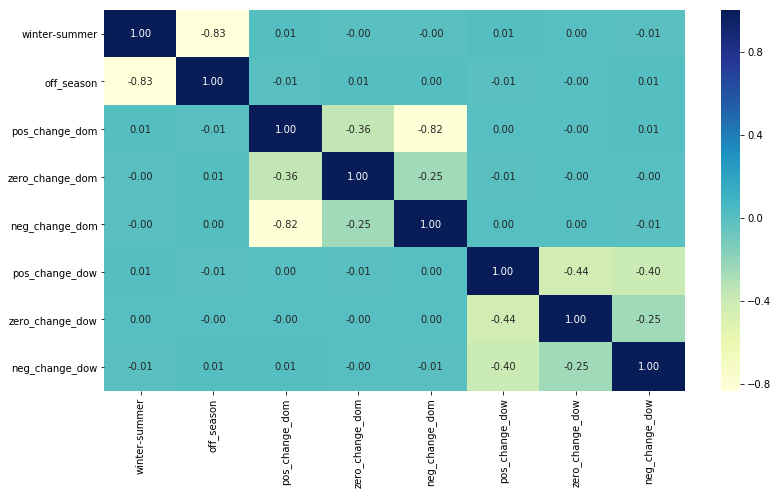

In [45]:
plt.figure(figsize=(13, 7)) 
sns.heatmap(date_features_df.corr('spearman'), annot=True, fmt='.2f', cmap="YlGnBu");

The resulting samples will consist of the following features:

In [46]:
X_sparse = csr_matrix(hstack([
    wpsr.values.reshape(-1, 1),
    date_features_df,
    one_hot_topics, 
    one_hot_tags, 
    title_tfidf, 
    text_tfidf,
]))

In [47]:
del titles_normalized, text_normalized,\
    title_tfidf, text_tfidf, date_features_df,\
    wpsr,one_hot_topics, one_hot_tags
gc.collect()

5908

### Part 7. Cross-validation, hyperparameter tuning

### Part 8. Validation and learning curves

In [48]:
# Memory usage optimization
del full_df, X
gc.collect()

7

In [49]:
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from vowpalwabbit.sklearn_vw import VWRegressor
from sklearn.ensemble import BaggingRegressor

In [50]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
def plot_validation_curve_gscv(gscv, param, logx=False):
    plot_func = plt.semilogx if logx else plt.plot
    res = gscv.cv_results_
    x = [p[param] for p in res['params']]

    # minus - neg-mse to mse
    mu, std = -res['mean_train_score'], res['std_train_score']
    lines = plot_func(x, mu, label='train')
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)

    # minus - neg-mse to mse
    mu, std = -res['mean_test_score'], res['std_test_score']
    lines = plot_func(x, mu, label='test')
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)
    plt.legend()
    plt.grid(True)
    
def plot_learning_curve(reg, tain_sizes, X, y):
    N_train, val_train, val_test = learning_curve(reg,  X, y, 
                                                  train_sizes=train_sizes, 
                                                  cv=KFold(n_splits=3, shuffle=True, random_state=17),
                                                  n_jobs=-1, scoring='neg_mean_squared_error')
    # minus - neg-mse to mse
    plot_with_err(N_train, -val_train, label='training scores')
    plot_with_err(N_train, -val_test, label='validation scores')
    plt.xlabel('Training Set Size'); 
    plt.ylabel('mse')
    plt.legend()
    plt.grid(True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.25, random_state=17)

In [52]:
train_sizes = np.linspace(0.05, 1, 10)

#### 1. Ridge (Linear with L2 reg and sgd solver)

In [53]:
%%time
parameters = {'alpha': np.logspace(-8, 2, 10)}
ridge_model = Ridge(random_state=17, solver='sag')
ridge_gscv = GridSearchCV(ridge_model, parameters, 
                          cv=cv=KFold(n_splits=3, shuffle=True, random_state=17),
                          scoring='neg_mean_squared_error',  n_jobs=-1,
                          return_train_score=True, verbose=5)
ridge_gscv.fit(X_train, y_train)
# minus - neg-mse to mse
print(-ridge_gscv.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 81.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 81.7min finished


0.7955083305753663
CPU times: user 23.5 s, sys: 801 ms, total: 24.3 s
Wall time: 1h 22min 7s


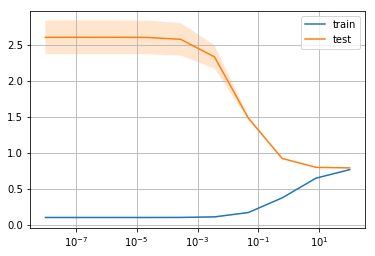

In [54]:
plot_validation_curve_gscv(ridge_gscv, 'alpha', True)

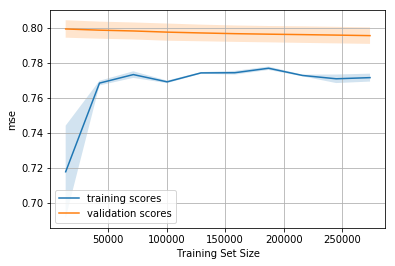

In [56]:
plot_learning_curve(ridge_gscv.best_estimator_, train_sizes, X_train, y_train)

#### 2.Bagging (Base model is Ridge)

In [57]:
%%time
parameters = {'n_estimators': np.arange(2, 19, 4)}
ridge_model_base = Ridge(random_state=17, solver='sag', alpha=ridge_gscv.best_params_['alpha'])
bagging_model = BaggingRegressor(ridge_model_base, random_state=17, verbose=True)
bagging_gscv = GridSearchCV(bagging_model, parameters, 
                          cv=KFold(n_splits=3, shuffle=True, random_state=17), scoring='neg_mean_squared_error', 
                          n_jobs=-1, return_train_score=True, verbose=5)
bagging_gscv.fit(X_train, y_train)
# minus - neg-mse to mse
print(-bagging_gscv.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 29.8min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 38.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7956378482620048
CPU times: user 9min 33s, sys: 9.65 s, total: 9min 42s
Wall time: 48min 13s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.7min finished


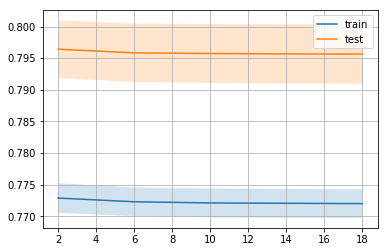

In [58]:
plot_validation_curve_gscv(bagging_gscv, 'n_estimators')

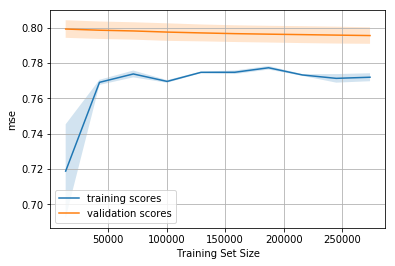

In [59]:
plot_learning_curve(bagging_gscv.best_estimator_, train_sizes, X_train, y_train)

Bagging does not bring any result. As can be seen in the graphs, regardless of the number of models, the result does not change.

#### 3. Vowpal Wabbit

In [60]:
%%time
parameters = {'l2': np.logspace(-8, -2, 6)}
wv_model = VWRegressor(loss_function='squared', random_seed=17)
vw_gscv = GridSearchCV(wv_model, parameters, 
                          cv=KFold(n_splits=3, shuffle=True, random_state=17),
                          scoring='neg_mean_squared_error', n_jobs=-1,
                          return_train_score=True, verbose=True)
vw_gscv.fit(X_train, y_train)
# minus - neg-mse to mse
print(-vw_gscv.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 50.1min finished


0.8032471544159974
CPU times: user 6min 28s, sys: 5.63 s, total: 6min 33s
Wall time: 56min 55s


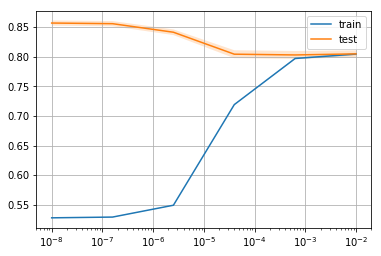

In [61]:
plot_validation_curve_gscv(vw_gscv, 'l2', logx=True)

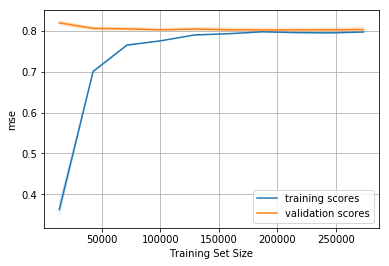

In [62]:
plot_learning_curve(vw_gscv.best_estimator_, train_sizes, X_train, y_train)

The result is almost the same as Ridge.

### Part 9. Prediction for hold-out and test samples 

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
ridge_best_model = ridge_gscv.best_estimator_
ridge_pred = ridge_best_model.predict(X_test)
mean_squared_error(y_test, ridge_pred)

0.7961115966681086

In [65]:
vw_best_model = vw_gscv.best_estimator_
vw_pred = vw_best_model.predict(X_test)
mean_squared_error(y_test, vw_pred)

0.8054962056201002

Let's try to combine predictions

In [66]:
coeffs = np.arange(0.1, 0.91, 0.1)
mse = [mean_squared_error(y_test, ridge_pred * c + vw_pred * (1 - c)) for c in coeffs]
m = np.argmin(mse)
coeffs[m], mse[m]

(0.9, 0.7961837326531745)

First 100 predictions

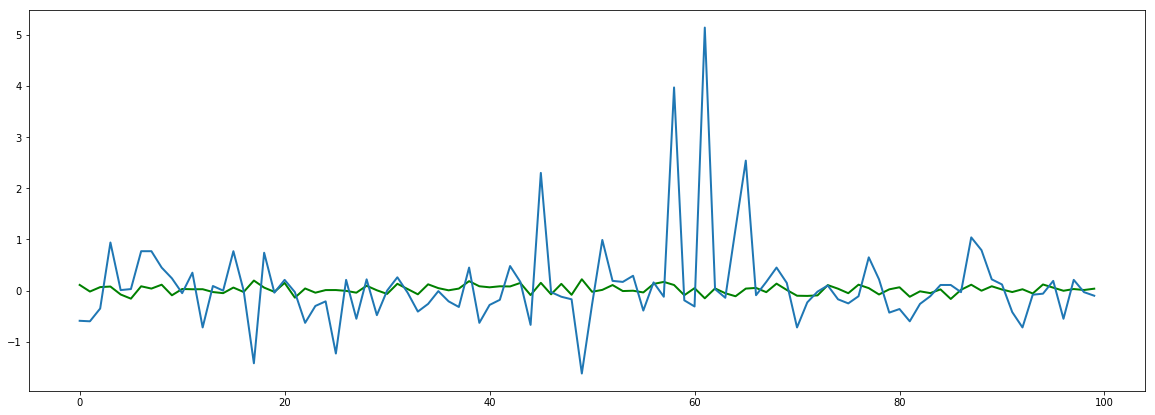

In [67]:
c = coeffs[m]
prediction = ridge_pred * c + vw_pred * (1 - c)
plt.figure(figsize=(20, 7))
plt.plot(prediction[:100], "g", label="prediction", linewidth=2.0)
plt.plot(y_test[:100].values, label="actual", linewidth=2.0)

Last 100 predictions

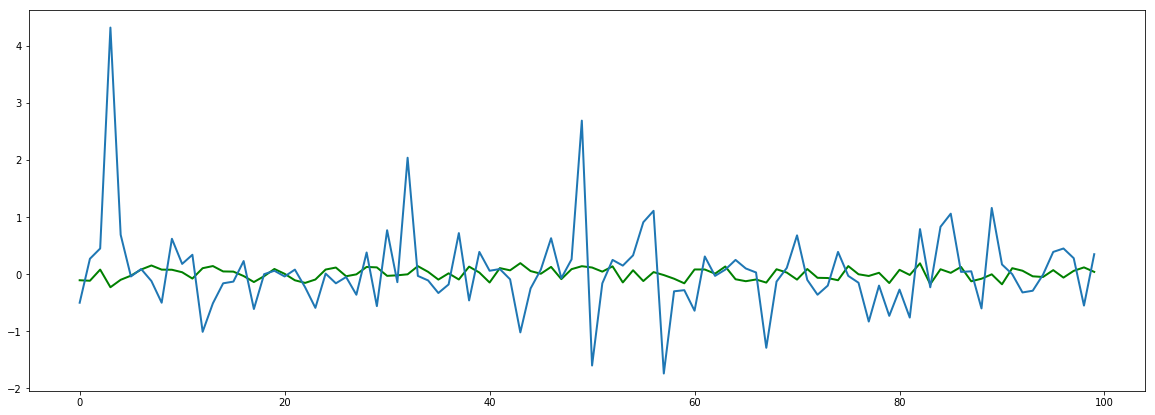

In [68]:
plt.figure(figsize=(20, 7))
plt.plot(prediction[-100:], "g", label="prediction", linewidth=2.0)
plt.plot(y_test[-100:].values, label="actual", linewidth=2.0)

Based on the comparison of predictions and true values, we can conclude that the model is failed.

### Part 10. Model evaluation with metrics description

Three models are considered as models:
1. Ridge
1. Bagging
1. Vowpal Wabbit

Selected metric is MSE.

MSE necessary to reduce errors, with a strong penalty for large errors.

Error around ~ 0.8 is pretty high, which allows to draw conclusions about the poor quality of the model.

### Part 11. Conclusions

During the individual project, the following actions were performed:
1. Necessary dataset created;
1. The values in the data set, including the values of the target variable, are explored;
1. The extreme values of the target variable are explored and which values in the data set affect the target variable;
1. An attempt was made to create new features;
1. Trained several models on the features;
1. The results were unsuccessful.

I tried several methods and approaches to the solution, but did not reach a positive result. I would be grateful for help in finding errors.